In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib; matplotlib.rcParams['figure.figsize'] = (15,3)

In [2]:
import numpy as np

In [3]:
# Reload all packages - make debugging easier
%load_ext autoreload
%autoreload 2

---

Use some matrix... just check if it trains and if so how quickly

In [4]:
# from movieLensAnalyzer import MovieLensAnalyzer 
# movieLensAnalyzer = MovieLensAnalyzer()
# R = movieLensAnalyzer.trainRatingMatrix

In [5]:
SPARSE = True

In [6]:
from movieLensAnalyzer import MovieLensAnalyzer 
movieLensAnalyzer = MovieLensAnalyzer()
R_train = movieLensAnalyzer.trainRatingMatrix
R_test = movieLensAnalyzer.testRatingMatrix
R = R_train + R_test

In [7]:
if not SPARSE:
    print("% of items: ", np.sum(R > 0) / (R.shape[0] * R.shape[1]))

    R_dense = np.copy(R)
    MIN_PERC_FILLED = 0.3

    idx = []
    # Remove items
    for j in range(R_dense.shape[1]):
        perc_filled = np.sum(R_dense[:,j] > 0) / R_dense.shape[0]
        if perc_filled >= MIN_PERC_FILLED:
            idx.append(j)
    R_dense = R_dense[:, idx]
    R_dense.shape

    idx = []
    # Remove users
    for i in range(R_dense.shape[0]):
        perc_filled = np.sum(R_dense[i,:] > 0) / R_dense.shape[1]
        if perc_filled >= MIN_PERC_FILLED:
            idx.append(i)
    R_dense = R_dense[idx, :]
    R_dense.shape

    print("% of items: ", np.sum(R_dense > 0) / (R_dense.shape[0] * R_dense.shape[1]))

    R = R_dense

---

In [8]:
NUM_USERS_DENSE = 20
NUM_USERS_SPARS = 20
PERC_DROP = 0.3 # approximately.

rating_density_per_user = list(zip(np.sum(R>0, axis=1), range(R.shape[0])))
dense_users = sorted(rating_density_per_user, key=lambda x: -x[0])[:NUM_USERS_DENSE]
spars_users = sorted(rating_density_per_user, key=lambda x:  x[0])[:NUM_USERS_SPARS]

train_mask = R > 0

# The test masks we'll use later.
test_masks = {}

# We artifically dropout some elements from the users we're interested in. Assume the rest of the matrix is filled.
np.random.seed(1337)
for _, idx in (dense_users + spars_users):
    before = np.copy(train_mask[idx, :])
    
    dropout = 1-np.random.binomial(1, PERC_DROP, size=R.shape[1])
    train_mask[idx, :] = dropout * train_mask[idx, :]
    
    test_mask = np.bitwise_xor(before, train_mask[idx, :])
    test_masks[idx] = test_mask

In [9]:
# sanity check
print(np.sum(train_mask))
print(np.sum([np.sum(m) for _, m in test_masks.items()]))

96944
3056


---

Our model.

Note we haven't fully cross validated yet, so the result is not be optimal.

In [10]:
from nnmf_vanilla import NNMFVanilla
model = NNMFVanilla(ratingMatrix=R)

---

Evaluation code. We'll look at the output for an arbituary user.

First, we look at the prior Rhats.

In [11]:
def plot_R(rhats, r=None, title=''):
    _, n_items = rhats.shape
    f, axes = plt.subplots(1, n_items, sharex=True, sharey=True)
    i = 0
    for j in range(n_items):
        if r is not None:
            axes[j].axvline(x=r[j], color='r', alpha=0.4)
        axes[j].hist(rhats[:,j], histtype='stepfilled', normed=True)
    plt.xlim([0,6])
    f.suptitle(title)
    plt.show()

TEST_USERS = [11]
    
def score():
    # For now, just some mse of random users.
    mses = []
    for user_index in TEST_USERS:
        print('User', user_index)
        idx = np.where(R[user_index] > 0)
        samples = np.squeeze(model.sample_for_user(user_index, 50)[:,idx], axis=(1,))
        rhats = np.mean(samples, axis=0)
        r = R[user_index][idx]
        print("Rhats :", np.round(rhats[:30]))
        print("Actual:", r[:30])
        mses.append(np.mean(np.square(rhats - r)))
    print("MSE per user", mses)

%time score()

User 11
Rhats : [-2. -2. -2. -2. -2. -2. -3. -1. -1. -2. -2. -2. -2. -2. -3. -2. -2. -2.
 -2. -2. -3. -2. -2. -1. -2. -1. -2. -2. -1. -1.]
Actual: [ 5.  5.  5.  4.  5.  4.  4.  5.  4.  5.  5.  4.  5.  4.  5.  5.  4.  5.
  4.  4.  4.  5.  5.  4.  5.  1.  4.  3.  5.  4.]
MSE per user [40.837776322217486]
CPU times: user 34 ms, sys: 3.83 ms, total: 37.8 ms
Wall time: 42.8 ms


Train, and look at posterior Rhats, as well as the MSE for each of our chosen users.

In [12]:
#mask = R>0

CPU times: user 1min 8s, sys: 10.8 s, total: 1min 18s
Wall time: 55.5 s
User 11
Rhats : [ 4.  4.  4.  5.  4.  4.  4.  4.  4.  4.  5.  5.  5.  4.  4.  4.  4.  4.
  5.  5.  5.  5.  5.  4.  4.  4.  4.  4.  4.  4.]
Actual: [ 5.  5.  5.  4.  5.  4.  4.  5.  4.  5.  5.  4.  5.  4.  5.  5.  4.  5.
  4.  4.  4.  5.  5.  4.  5.  1.  4.  3.  5.  4.]
MSE per user [0.64018090722287102]


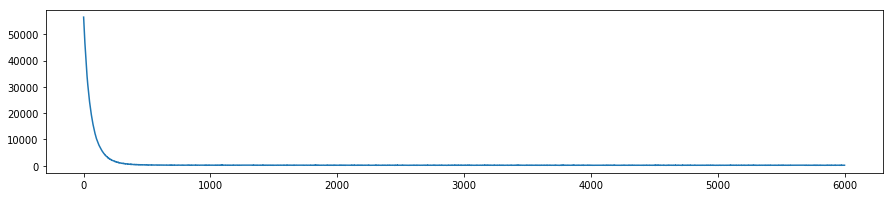

In [13]:
%time losses = model.train(legalTrainIndices=train_mask)
plt.plot(losses)
score()

In [14]:
#model.save('nnmf_vanilla_6000.pkl')
model.save('nnmf_vanilla_sparse_6000_simple_architecture.pkl')

'nnmf_vanilla_sparse_6000_simple_architecture.pkl'

---

Test save, load, reset.

In [15]:
model.save('bla.pkl') # We save as pickles. It would be better (for style) if you use the .pkl extension.

'bla.pkl'

In [16]:
model.reset()

In [17]:
score()

User 11
Rhats : [-2. -2. -2. -3. -2.  0. -2. -2. -2. -2. -1. -2. -3. -2. -1. -3. -2. -2.
 -1. -1. -2.]
Actual: [ 1.  1.  4.  4.  3.  5.  1.  3.  2.  5.  3.  3.  4.  3.  5.  2.  4.  4.
  3.  2.  3.]
MSE per user [25.405309953042654]


In [18]:
model.load('bla.pkl')

In [19]:
score()

User 11
Rhats : [ 3.  3.  3.  3.  3.  4.  3.  3.  4.  3.  3.  3.  3.  3.  3.  3.  3.  4.
  3.  3.  3.]
Actual: [ 1.  1.  4.  4.  3.  5.  1.  3.  2.  5.  3.  3.  4.  3.  5.  2.  4.  4.
  3.  2.  3.]
MSE per user [1.3104257180700534]
